In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import joblib


In [11]:
df = pd.read_csv("dataset.csv")



In [12]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month


C:\Users\Dell\AppData\Local\Temp\ipykernel_18716\1407158939.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])


In [13]:
print(df.columns)
df[['trans_date_trans_time','hour','day','month']].head()


Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'hour', 'day', 'month'],
      dtype='object')


,trans_date_trans_time,hour,day,month
0,2019-03-14 13:58:00,13,14,3
1,2019-01-06 03:04:00,3,6,1
2,2019-01-21 07:33:00,7,21,1
3,2019-01-31 14:17:00,14,31,1
4,2019-02-02 06:17:00,6,2,2


In [14]:
df_original = df.copy()  # keep original text table

cat_cols = ['merchant','category','gender']
encoders = {}

for col in cat_cols:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])


In [15]:
df[['lat','long','merch_lat','merch_long']].head()


,lat,long,merch_lat,merch_long
0,24.406549,-69.906598,24.405948,-69.923184
1,25.871033,58.541408,25.840670,58.567599
2,7.649299,88.835270,7.620422,88.769003
3,-24.978473,80.421538,-24.955338,80.422182
4,-2.479384,100.577208,-2.453657,100.590146


In [16]:
def haversine(lat1, lon1, lat2, lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

# ensure df_model exists (copy original dataframe so we don't modify df)
df_model = df.copy()

df_model['distance'] = haversine(df_model['lat'], df_model['long'],
                                 df_model['merch_lat'], df_model['merch_long'])

In [17]:
print(df.columns.tolist())


['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day', 'month']


In [18]:
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
X = df_model[features]
y = df_model['is_fraud']



In [19]:
smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(X, y)

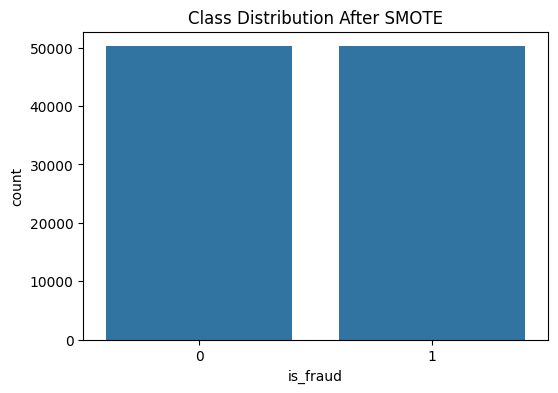

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X_resample,y_resample,test_size=0.2, random_state=42)

In [22]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)

lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 40256, number of negative: 40163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 80419, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500578 -> initscore=0.002313
[LightGBM] [Info] Start training from score 0.002313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [23]:
y_pred = lgb_model.predict(x_test)

In [24]:
print("Classification_Report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score:", roc_auc_score(y_test, y_pred))

Classification_Report:
               precision    recall  f1-score   support

           0       0.50      0.38      0.44     10099
           1       0.50      0.62      0.55     10006

    accuracy                           0.50     20105
   macro avg       0.50      0.50      0.49     20105
weighted avg       0.50      0.50      0.49     20105

Roc AUC Score: 0.5017161403326338


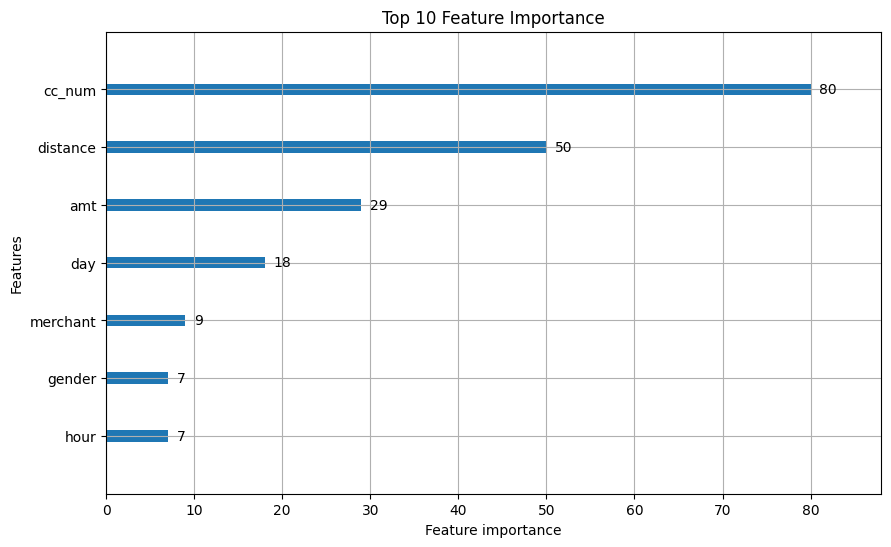

In [25]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.title("Top 10 Feature Importance")
plt.show()

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

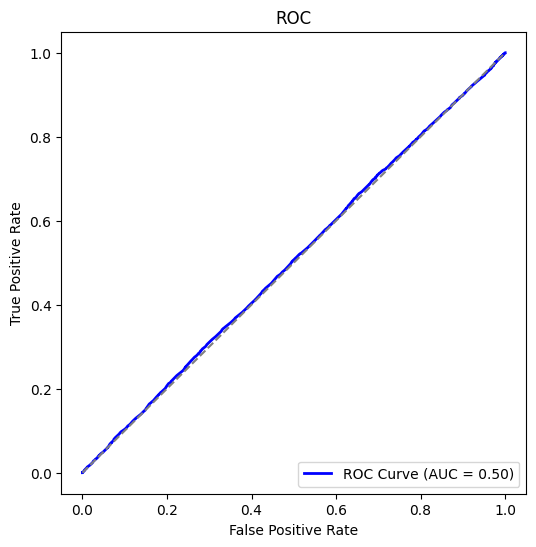

In [27]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [28]:
joblib.dump(lgb_model, "fraud_detection_model.jb")
joblib.dump(encoders, "Label_encoder.jb")

['Label_encoder.jb']

In [29]:
print(df.columns)


Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'hour', 'day', 'month'],
      dtype='object')


In [30]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2019-03-14 13:58:00,4.150000e+15,0,2,426.72,Lucas,Jones,1,117 Oxford Road,Sydney,...,Doctor,13-02-1991,INTL_TXN_0_4561,1552571902,24.405948,-69.923184,1,13,14,3
1,2019-01-06 03:04:00,4.460000e+15,16,4,117.66,Ava,Jones,0,567 Oxford Road,Berlin,...,Designer,16-06-1970,INTL_TXN_1_6932,1546743840,25.840670,58.567599,0,3,6,1
2,2019-01-21 07:33:00,4.330000e+15,4,3,759.46,Sophia,Miller,1,168 Park Avenue,Sydney,...,Doctor,07-08-1971,INTL_TXN_2_5583,1548056034,7.620422,88.769003,1,7,21,1
3,2019-01-31 14:17:00,4.310000e+15,10,7,715.37,Sophia,Johnson,0,993 Park Avenue,Toronto,...,Developer,19-12-1984,INTL_TXN_3_9226,1548944241,-24.955338,80.422182,1,14,31,1
4,2019-02-02 06:17:00,4.710000e+15,7,2,102.89,Oliver,Lopez,0,255 Queen Avenue,Toronto,...,Manager,03-06-1985,INTL_TXN_4_7813,1549088265,-2.453657,100.590146,1,6,2,2
